# RAG Semantic Chunking Experiment

In this experiment, we'll compare the simplest chunking method, fixed-size chunking, with the improvements offered by semantic chunking.

The goal of semantic chunking is to create meaningful and context-aware chunks.

Traditional text splitting methods often divide documents at arbitrary points, which can disrupt the flow of information and context. Semantic chunking aims to address this by splitting text at more natural breakpoints, thereby preserving semantic coherence within each chunk.

In this example notebook, we’ll show how to create more coherent and contextually relevant chunks. We’ll first implement semantic chunking from scratch, step by step, and then demonstrate how libraries like LangChain can achieve the same with just a few lines of code. This approach will help us understand what semantic chunking does behind the scenes.

The components/tools used in this experiment are:

- Embedding Model: Cohere's embed-english-v3.0 model via[ LangChain's Cohere Embedding interface](https://python.langchain.com/v0.2/api_reference/cohere/embeddings/langchain_cohere.embeddings.CohereEmbeddings.html). API keys are available [here](https://dashboard.cohere.com/api-keys). 
- LangChain Text Splitter: [SemanticChunker](https://python.langchain.com/v0.2/docs/how_to/semantic-chunker/)

# Parameters

The following parameters are used in the experiment.

In [1]:
######## Parameters #########

# Data
FILE_PATH = "data/random_facts.txt"

# Naive Chunking
CHUNK_SIZE = 128

# Data

First, let's load up our toy dataset for this experiment. I created this dataset specifically to demonstrate how semantic chunking can produce more coherent chunks compared to using a fixed chunk size.

> Make sure the `random_facts.txt` data is present in [data](data/random_facts.txt) folder.

The dataset contains 30 sentences from 10 short paragraphs, meaning the ground truth should be **10 distinct chunks**. Since these paragraphs cover unrelated topics, we expect the embedding similarity between them to be significantly different, indicating they are semantically dissimilar."

In [2]:
with open(FILE_PATH) as f:
    random_facts = f.read()

# A Naive Approach - Fixed Size Chunking

Fixed size chunking is one of the most basic form of splitting up some texts. It is a method of dividing text into chunks or segments of a predetermined length, usually based on a specific number of characters, words, or tokens.

It's not a great chunking approach for a production system but it's the simplest the implement in when you are learning about RAG.

- Pros:
    - Easy & Simple
- Cons:
    - Loss of Coherence: Splitting at arbitrary points which can make the chunks difficult to understand.
    - Contextual Disconnection: Important contextual information might be split across chunks.
    - Does not take into account the structure of the text.

In [3]:
def fixed_size_chunker(text: str, chunk_size: int) -> list[str]:
    """Splits the input text into chunks of fixed character size.

    Args:
        text (str): text to chunk.
        chunk_size (int): number of character in a chunk.

    Returns:
        list[str]: chunked text
    """
    # Create chunks of the specified size
    chunks = [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]

    return chunks

In [4]:
fixed_size_chunks = fixed_size_chunker(text=random_facts, chunk_size=CHUNK_SIZE)
fixed_size_chunks

['Deep in the lush forests of Madagascar, the elusive aye-aye uses its long, thin middle finger to tap on trees, listening for the',
 ' echoes that indicate the presence of grubs. This nocturnal primate, often mistaken for a rodent, defies conventional evolutiona',
 "ry paths, showcasing nature's unpredictable creativity.\n\nQuantum computing, leveraging the principles of superposition and entan",
 'glement, promises to revolutionize industries by solving problems currently deemed intractable for classical computers. As resea',
 'rchers push the boundaries of quantum mechanics, the potential applications range from cryptography to drug discovery, heralding',
 ' a new era of technological advancement.\n\nIn the remote, frozen expanses of Antarctica, emperor penguins huddle together in mass',
 'ive colonies to survive the brutal winter. These birds endure some of the most extreme conditions on Earth, relying on their col',
 'lective warmth and energy to protect themselves from the pierci

In [5]:
print(f"{len(fixed_size_chunks)} chunks were made based on the chunk size of {CHUNK_SIZE} characters per chunk.")

30 chunks were made based on the chunk size of 128 characters per chunk.


That's it, we now have 30 chunks! We now have some text ready to be indexed for our RAG. However, you'll notice that the chunks are quite disjointed and cover completely different topics, which isn’t ideal.

# Semantic Chunking From Scratch

So, we’ve seen why using a global constant for chunk size might not give us the desired results. Now, let's explore how we can chunk our texts in a way that breaks sentences more naturally and creates more meaningful chunks.

The first question is how to represent the semantic meaning of a string. We can use embeddings, which are numerical representations of text. By comparing the distances between these embeddings, we can determine if two strings are semantically similar. This approach will be the key idea to our semantic chunking process.

Here’s the flow:
1. Split the Document: Start by dividing the document into individual sentences.
2. Generate Embeddings: Create embeddings for each sentence.
3. Calculate Distances: Compute the distance between each consecutive pair of sentences.
4. Set a Threshold: Determine a threshold distance to decide whether a sentence is semantically similar enough to belong to the same chunk or if it should start a new chunk.

Finally, if the distance is small, indicating semantic similarity, we’ll group these sentences into the same chunk or if the distance is large, we’ll assign the sentences to separate chunks.

<p align="center">
    <img src="assets/semantic_chunking.png" width="1300"/>
</p>

## Step 1 - Sentence Splitting

The first step of semantic chunking is to split the document into individual sentences. 

This can be done by implementing a simple splitter that divides the text based on common sentence-ending punctuation marks like ".", "?", and "!". 

This provides a foundation for more meaningful semantic analysis in the next steps.

In [6]:
import re


def sentence_spliter(document: str) -> list[str]:
    # Splitting the essay on '.', '?', and '!'
    single_sentences_list = re.split(r"(?<=[.?!])\s+", document)
    print (f"{len(single_sentences_list)} sentences were found")

    return single_sentences_list

In [7]:
single_sentences_list = sentence_spliter(random_facts)

24 sentences were found


Our experiment data are have split it into 24 individual sentences (chunks) based on punctuation marks.

Using a list to store sentences is ok, but it becomes challenging when we need to add more data, such as metadata, sentence positions, and other relevant information.

In production, we rarely work with just lists of strings. It's more common to work with `Document` objects that not only hold the text but also make it easier to manage additional data, making our workflow more efficient.

In [8]:
sentences = [{"sentence": x, "index" : i} for i, x in enumerate(single_sentences_list)]
sentences[:3]

[{'sentence': 'Deep in the lush forests of Madagascar, the elusive aye-aye uses its long, thin middle finger to tap on trees, listening for the echoes that indicate the presence of grubs.',
  'index': 0},
 {'sentence': "This nocturnal primate, often mistaken for a rodent, defies conventional evolutionary paths, showcasing nature's unpredictable creativity.",
  'index': 1},
 {'sentence': 'Quantum computing, leveraging the principles of superposition and entanglement, promises to revolutionize industries by solving problems currently deemed intractable for classical computers.',
  'index': 2}]

For simplicity, we will create a simple list of dictionary which includes the position of our sentence chunks.

## Step 2 - Generate Embeddings

Once we have our sentences separated, the next step is to generate embeddings for each sentence.

An embedding is a numerical representation of text that captures its semantic meaning. By converting sentences into embeddings, we create a way to quantitatively compare their meanings. 

This step is crucial because it transforms our text data into a format that allows us to measure how similar or different the sentences are from one another.

We will use Cohere's embedding API for to generate our embeddings.

In [9]:
import getpass

from langchain_cohere import CohereEmbeddings

# initialise connection to Cohere (get API key at dashboard.cohere.com/api-keys)
api_key = getpass.getpass()

embed_model = CohereEmbeddings(cohere_api_key=api_key, model="embed-english-v3.0")

/Users/oscar/Library/Caches/pypoetry/virtualenvs/rag-semantic-chunking-Qn654Svd-py3.10/lib/python3.10/site-packages/pydantic/_internal/_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has been renamed to 'populate_by_name'
* 'smart_union' has been removed
  warnings.warn(message, UserWarning)


In [10]:
embeddings = embed_model.embed_documents([sentence["sentence"] for sentence in sentences])

for i, sentence in enumerate(sentences):
    sentence["embedding"] = embeddings[i]

We will store the sentence embeddings in our sentence dictionary.

In [11]:
sentences[:1]

[{'sentence': 'Deep in the lush forests of Madagascar, the elusive aye-aye uses its long, thin middle finger to tap on trees, listening for the echoes that indicate the presence of grubs.',
  'index': 0,
  'embedding': [-0.008285522,
   -0.030273438,
   0.06298828,
   0.024917603,
   -0.03677368,
   0.031799316,
   0.036346436,
   -0.031799316,
   0.019165039,
   0.035095215,
   -0.052703857,
   0.0046310425,
   -0.020095825,
   -0.005027771,
   -0.04916382,
   -0.0463562,
   -0.005672455,
   0.017181396,
   0.018539429,
   -0.0018262863,
   0.021331787,
   -0.0021762848,
   -0.0138168335,
   -0.06451416,
   0.049041748,
   -0.0065078735,
   -0.012130737,
   0.027297974,
   0.027191162,
   0.026657104,
   0.034423828,
   -0.04736328,
   0.01197052,
   0.03488159,
   -0.022567749,
   0.0023269653,
   0.004562378,
   -0.011459351,
   0.009010315,
   0.019699097,
   0.04647827,
   -0.037078857,
   -0.03466797,
   0.016433716,
   -0.047790527,
   0.012954712,
   0.008087158,
   -0.00298118

## Step 3 - Calculating the Distance Between Consecutive Sentences

With embeddings generated, we then calculate the distance between each consecutive pair of sentences.

The distance is a measure of how similar or dissimilar the sentences are in terms of their semantic content.

Typically, a smaller distance indicates that the sentences are more related in meaning, while a larger distance suggests they are less related. This step helps us quantify the relationship between sentences, which is essential for determining how to group them into chunks.

We want to use the distances to look for "break points".

In [12]:
from sklearn.metrics.pairwise import cosine_similarity


def calculate_cosine_distances(sentences):
    distances = []
    for i in range(len(sentences) - 1):
        embedding_current = sentences[i]["embedding"]
        embedding_next = sentences[i + 1]["embedding"]

        # Calculate cosine similarity
        similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]

        # Convert to cosine distance
        distance = 1 - similarity

        # Append cosine distance to the list
        distances.append(distance)

        # Store distance in the dictionary
        sentences[i]["distance_to_next"] = distance

    return distances, sentences

In [13]:
distances, sentences = calculate_cosine_distances(sentences)

Below are the distances we calculated between each sentence and the one that follows it. The first distance represents the distance between the sentence at index 0 and the sentence at index 1. The second distance is between the sentences at index 1 and index 2, and so on.

In [14]:
distances

[0.5749485157071853,
 0.7809298578875499,
 0.35513687004113814,
 0.8347391382690689,
 0.43821680405491814,
 0.796642883920948,
 0.4300332746109623,
 0.507195119448405,
 0.7926840079371905,
 0.48172305448808783,
 0.5169515356327596,
 0.649423006982539,
 0.36497902932476245,
 0.5340626229765926,
 0.5402646549618089,
 0.7501458916480221,
 0.5474308935134968,
 0.7244863479796516,
 0.44094045830348405,
 0.8687634751564599,
 0.49394208516141536,
 0.7412934004730473,
 0.41556463981195746]

In [15]:
# Adding the distance to our data structure

sentences[:1]

[{'sentence': 'Deep in the lush forests of Madagascar, the elusive aye-aye uses its long, thin middle finger to tap on trees, listening for the echoes that indicate the presence of grubs.',
  'index': 0,
  'embedding': [-0.008285522,
   -0.030273438,
   0.06298828,
   0.024917603,
   -0.03677368,
   0.031799316,
   0.036346436,
   -0.031799316,
   0.019165039,
   0.035095215,
   -0.052703857,
   0.0046310425,
   -0.020095825,
   -0.005027771,
   -0.04916382,
   -0.0463562,
   -0.005672455,
   0.017181396,
   0.018539429,
   -0.0018262863,
   0.021331787,
   -0.0021762848,
   -0.0138168335,
   -0.06451416,
   0.049041748,
   -0.0065078735,
   -0.012130737,
   0.027297974,
   0.027191162,
   0.026657104,
   0.034423828,
   -0.04736328,
   0.01197052,
   0.03488159,
   -0.022567749,
   0.0023269653,
   0.004562378,
   -0.011459351,
   0.009010315,
   0.019699097,
   0.04647827,
   -0.037078857,
   -0.03466797,
   0.016433716,
   -0.047790527,
   0.012954712,
   0.008087158,
   -0.00298118

## Step 4 - Finding Sentences Breakpoint

In this final step, we set a threshold distance to determine how sentences should be grouped.

If the distance between two sentences is below this threshold, we consider them similar enough to belong to the same chunk. However, if the distance exceeds the threshold, we treat the sentences as semantically distinct and assign them to separate chunks.

This threshold is crucial for ensuring that our chunks are both meaningful and coherent, we want chunks to reflect the natural breaks in the document's content.

The method used to determine this threshold can vary depending on your use case. Here, we’re looking for patterns that meaningfully separate chunks. For instance, in a large dataset, outliers in the distance measurements might indicate sentences that should be isolated into their own chunks.

Let's plot the distance into a graph and help us understand our chunks better.

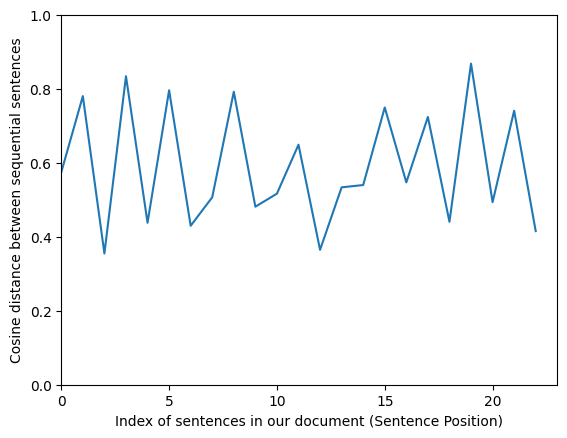

In [16]:
import matplotlib.pyplot as plt

plt.plot(distances)
y_upper_bound = 1.0
plt.ylim(0, y_upper_bound)
plt.xlim(0, len(distances))

plt.xlabel("Index of sentences in our document (Sentence Position)")
plt.ylabel("Cosine distance between sequential sentences")
plt.show()

The graph above shows a clear pattern where the distance between sentences fluctuates, consistently rising and then dropping every two indexes. This pattern can help us pinpoint where one chunk ends and the next begins.

For our experimental dataset, this pattern could be used to differentiate the 10 distinct paragraphs, each covering a different topic. In an ideal scenario with a perfect algorithm, we would expect to see 10 distinct chunks, corresponding to the 10 different topics.

In practice, there are various ways to chunk the text based on these distances, and it's not always trivial where the threshold should be. You would want to experiment with different threshold to get the chunking results you want.

In our case, we want to get something like this.

<img src="assets/ideal_threshold.png" width="550"/>

Using percentiles is a common method for determining breakpoints. LangChain offers a range of methods for identifying breakpoints, including percentile, standard deviation, and interquartile range, and more.

### Calculating The Breakpoint

We want to find our what's the value of the 90th percentile.

In [17]:
import numpy as np

percentile_threshold = 90 # We will start with 90th percentile of distance as a break point, this means any distance that goes above the 90th percentile will be break up into the next chunks.

# We need to get the distance threshold that we'll consider an outlier
# We'll use numpy .percentile() for this
breakpoint_distance_threshold = np.percentile(distances, percentile_threshold)
breakpoint_distance_threshold


0.7958511087241965

Now that we have the 90th percentile, we want to identify which sentences have a distance to the next sentence that exceeds this threshold.

In [18]:
indices_above_thresh = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold] # The indices of sentences which we want to break
indices_above_thresh

[3, 5, 19]

So what does this mean? We only have 4 chunks? (It's +1 to the length of indices_above_thresh because we have another after the last break point.)

Maybe this threshold is too high since we are expecting around 10 chunks.

Let's plot this to get a better visualisation of what's going on.

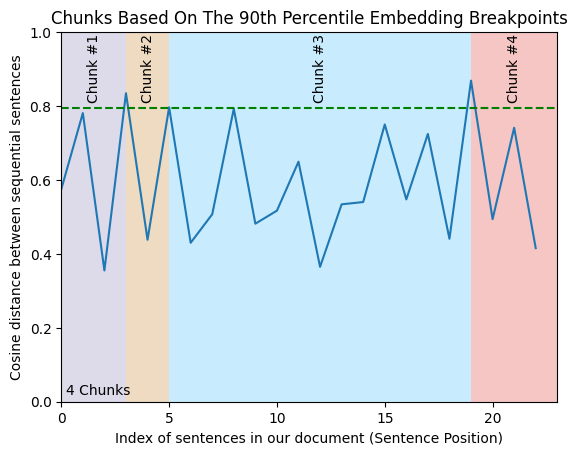

In [19]:
plt.plot(distances)

# Define bounds for the plot
y_upper_bound = 1.0
plt.ylim(0, y_upper_bound)
plt.xlim(0, len(distances))

# Threshold line
plt.axhline(y=breakpoint_distance_threshold, color="g", linestyle="--")

# Count distances above the threshold and find their indices
num_chunks = len(indices_above_thresh) + 1 # +1 because we have another after the last break point.
plt.text(x=(len(distances) * 0.01), y=y_upper_bound / 50, s=f"{num_chunks} Chunks")

# Start of the shading and text
previous_index = 0

# Define random color for each chunks
colours = [(np.random.random(), np.random.random(), np.random.random()) for _ in range(num_chunks)]

# Separate each chunks with vertical colour band
for i, breakpoint_index in enumerate(indices_above_thresh + [len(distances)]):
    plt.axvspan(previous_index, breakpoint_index, facecolor=colours[i], alpha=0.25)
    plt.text(x=np.average([previous_index, breakpoint_index]),
             y=breakpoint_distance_threshold + (y_upper_bound) / 50,
             s=f"Chunk #{i + 1}",
             horizontalalignment="center",
             rotation="vertical")
    previous_index = breakpoint_index

# Titles & labels
plt.title("Chunks Based On The 90th Percentile Embedding Breakpoints")
plt.xlabel("Index of sentences in our document (Sentence Position)")
plt.ylabel("Cosine distance between sequential sentences")
plt.show()


From the diagram above, we can see that the threshold isn't quite where we want it to be. This might be due to the size and nature of the dataset, there isn't a lot of data, and the differences in distances aren't significant enough. The simplest solution here is to lower the percentile value.

In [20]:
percentile_threshold = 70 # Lowering the break point threshold.

breakpoint_distance_threshold = np.percentile(distances, percentile_threshold)

indices_above_thresh = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold] # The indices of sentences which we want to break
indices_above_thresh

[1, 3, 5, 8, 15, 19, 21]

This time we can see we got 7 indices that are above our break point threshold. Let's plot a diagram.

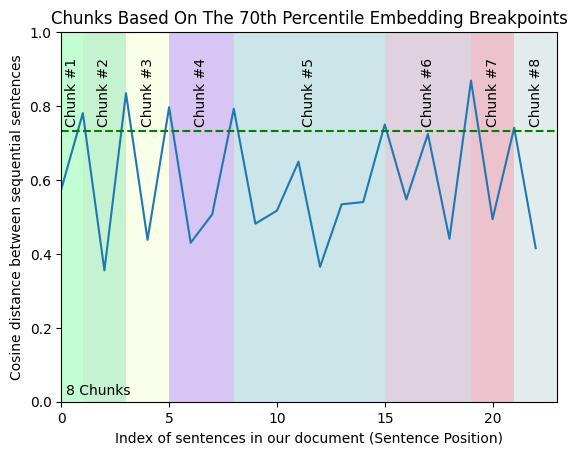

In [21]:
plt.plot(distances)

# Define bounds for the plot
y_upper_bound = 1.0
plt.ylim(0, y_upper_bound)
plt.xlim(0, len(distances))

# Threshold line
plt.axhline(y=breakpoint_distance_threshold, color="g", linestyle="--")

# Count distances above the threshold and find their indices
num_chunks = len(indices_above_thresh) + 1 # +1 because we have another after the last break point.
plt.text(x=(len(distances) * 0.01), y=y_upper_bound / 50, s=f"{num_chunks} Chunks")

# Start of the shading and text
previous_index = 0

# Define random color for each chunks
colours = [(np.random.random(), np.random.random(), np.random.random()) for _ in range(num_chunks)]

# Separate each chunks with vertical colour band
for i, breakpoint_index in enumerate(indices_above_thresh + [len(distances)]):
    plt.axvspan(previous_index, breakpoint_index, facecolor=colours[i], alpha=0.25)
    plt.text(x=np.average([previous_index, breakpoint_index]),
             y=breakpoint_distance_threshold + (y_upper_bound) / 50,
             s=f"Chunk #{i + 1}",
             horizontalalignment="center",
             rotation="vertical")
    previous_index = breakpoint_index

# Titles & labels
plt.title("Chunks Based On The 70th Percentile Embedding Breakpoints")
plt.xlabel("Index of sentences in our document (Sentence Position)")
plt.ylabel("Cosine distance between sequential sentences")
plt.show()


Lowering the threshold results in a significantly higher number of chunks.

Since we know that our dataset should ideally be split into around 10 chunks, we can see that this lower threshold aligns better with our expectations. However, in practice, the exact number of chunks is often unknown in advance. Finding the optimal threshold usually involves trial and error to determine which configuration gives the desired RAG response.

Enough for graphs and visualisation, let's actually generate our chunks based on the threshold.

In [22]:
indices_above_thresh # This will be used to determine when a chunk should end

[1, 3, 5, 8, 15, 19, 21]

In [23]:
# Initialise the start index
start_index = 0

# Create a list to hold the grouped sentences
chunks = []

# Iterate through the breakpoints to slice the sentences
for end_index in indices_above_thresh:
    # Slice the sentences from the current start index to the end index
    group = sentences[start_index:end_index + 1]
    combined_text = " ".join(d["sentence"] for d in group)
    chunks.append(combined_text)

    # Update the start index for the next group
    start_index = end_index + 1

# Add the last group, if there are remaining sentences
if start_index < len(sentences):
    combined_text = " ".join(d["sentence"] for d in sentences[start_index:])
    chunks.append(combined_text)

# grouped_sentences now contains the chunked sentences

Final chunk result.

In [24]:
semantic_chunks = chunks
for chunk in semantic_chunks:
    print(chunk)

Deep in the lush forests of Madagascar, the elusive aye-aye uses its long, thin middle finger to tap on trees, listening for the echoes that indicate the presence of grubs. This nocturnal primate, often mistaken for a rodent, defies conventional evolutionary paths, showcasing nature's unpredictable creativity.
Quantum computing, leveraging the principles of superposition and entanglement, promises to revolutionize industries by solving problems currently deemed intractable for classical computers. As researchers push the boundaries of quantum mechanics, the potential applications range from cryptography to drug discovery, heralding a new era of technological advancement.
In the remote, frozen expanses of Antarctica, emperor penguins huddle together in massive colonies to survive the brutal winter. These birds endure some of the most extreme conditions on Earth, relying on their collective warmth and energy to protect themselves from the piercing cold and relentless winds.
In the fast-p

The chunks we obtained from semantic chunking are significantly more meaningful compared to those produced by fixed-size chunking. Each chunk is much more semantically coherent, reflecting a better understanding of the text’s context and content.

Taking the first paragraph for example, this is the what we have.

| Ground Truth| Fixed Size Chunking | Semantic Chunking |
| --- | --- | --- |
| Deep in the lush forests of Madagascar, the elusive aye-aye uses its long, thin middle finger to tap on trees, listening for the echoes that indicate the presence of grubs. This nocturnal primate, often mistaken for a rodent, defies conventional evolutionary paths, showcasing nature's unpredictable creativity. | ['Deep in the lush forests of Madagascar, the elusive aye-aye uses its long, thin middle finger to tap on trees, listening for the']<br><br>[' echoes that indicate the presence of grubs. This nocturnal primate, often mistaken for a rodent, defies conventional evolutiona']<br><br>["ry paths, showcasing nature's unpredictable creativity.\n\nQuantum computing, leveraging the principles of superposition and entan"] | Deep in the lush forests of Madagascar, the elusive aye-aye uses its long, thin middle finger to tap on trees, listening for the echoes that indicate the presence of grubs. This nocturnal primate, often mistaken for a rodent, defies conventional evolutionary paths, showcasing nature's unpredictable creativity. |

Although semantic chunking is still not perfect, but we manage narrow down from the 30 chunks we got initially with fixed size chunking down to 8 chunks which is much closer to our ground truth, 10 chunks.

# Semantic Chunking With LangChain

Now that we've explored how semantic chunking works behind the scenes, we should have a much better understanding of its inner workings.

Fortunately, we don't need to implement semantic chunking from scratch ourselves. Libraries like LangChain's SemanticChunker, LlamaIndex's Semantic Chunker, or the RollingWindowSplitter from Semantic-Router already offer ready-made implementations. This means we can focus on applying semantic chunking without worrying about the complexities of building and testing our own implementation.

For this experiment, we will use LangChain's SemanticChunker, as it offers more options for computing breakpoints.


In [25]:
from langchain_experimental.text_splitter import SemanticChunker

# Initialising the chunker with Cohere's embedding API.
text_splitter = SemanticChunker(embed_model, breakpoint_threshold_type="percentile", breakpoint_threshold_amount=70)

# Splitting our data
docs = text_splitter.create_documents([random_facts])

# Semantic chunking with two lines of code
docs

[Document(page_content="Deep in the lush forests of Madagascar, the elusive aye-aye uses its long, thin middle finger to tap on trees, listening for the echoes that indicate the presence of grubs. This nocturnal primate, often mistaken for a rodent, defies conventional evolutionary paths, showcasing nature's unpredictable creativity."),
 Document(page_content='Quantum computing, leveraging the principles of superposition and entanglement, promises to revolutionize industries by solving problems currently deemed intractable for classical computers. As researchers push the boundaries of quantum mechanics, the potential applications range from cryptography to drug discovery, heralding a new era of technological advancement.'),
 Document(page_content='In the remote, frozen expanses of Antarctica, emperor penguins huddle together in massive colonies to survive the brutal winter. These birds endure some of the most extreme conditions on Earth, relying on their collective warmth and energy to

Almost identical result as we had before with our own implementation but with only a few lines of code.

# A Method for Quantifying How Semantic Chunking Produces More Concise Chunks

A simple way to assess the improvement in a chunking algorithm’s semantic precision is by computing the mean distance between neighbouring chunks. 

In semantic chunking, the goal is to group sentences or paragraphs based on their semantic difference, ensuring that each new chunk represents a meaningful shift in content. 

Therefore, the mean distance between consecutive chunks should be larger when using semantically-driven chunking, compared to fixed-size, naive chunking. 

This difference highlights the algorithm's ability to identify and segment distinct ideas more effectively.

In [26]:
from statistics import mean

def compute_mean_distance(chunks: list[str]) -> float:
    """Compute the mean cosine distance between consecutive neighbouring chunks.

    Args:
        chunks (list[str]): List of text chunks generated by a chunker.

    Returns:
        float: The mean cosine distance between consecutive chunks.
    """
    # Generate embeddings for all chunks
    embeddings = embed_model.embed_documents(chunks)
    
    # Calculate cosine distances between consecutive embeddings
    distances = [
        1 - cosine_similarity([embeddings[i]], [embeddings[i + 1]])[0][0]
        for i in range(len(chunks) - 1)
    ]
    
    return mean(distances)

## Mean Distance For Fixed Size Chunks

In [27]:
compute_mean_distance(fixed_size_chunks)


0.5911671717943463

## Mean Distance For Semantic Chunks

In [28]:
compute_mean_distance(semantic_chunks)

0.808939555795959

We can see that the mean chunk distance is indeed larger for semantic chunks.